In [10]:
import torch

import numpy as np
import pandas as pd

import math 
from tqdm import tqdm

from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.nn.representation import LabelBasedTransformerRepresentation
import pykeen.nn
from pykeen.sampling import BasicNegativeSampler
from pykeen.models import predict

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

### DataLoader

In [2]:
training = TriplesFactory.from_path(
    'data//pykeen//train.txt',
    entity_to_id = {str(i): i for i in range(20619)})
testing = TriplesFactory.from_path(
   'data//pykeen//test.txt',
    entity_to_id=training.entity_to_id,
    relation_to_id=training.relation_to_id)
neg_testing = TriplesFactory.from_path(
   'data//pykeen//test_neg.txt',
    entity_to_id=training.entity_to_id,
    relation_to_id=training.relation_to_id)

### Train

In [3]:
def train_pykeen(name_model):
    result = pipeline(
        training = training,
        testing = testing,
        model=name_model,
        training_loop='sLCWA',
        model_kwargs = dict(embedding_dim = 128),
        optimizer = "Adam",
        optimizer_kwargs = dict(lr = 0.0001),
        loss = "pairwiselogistic",
        negative_sampler="basic",
        negative_sampler_kwargs=dict(num_negs_per_pos=100),
        training_kwargs = dict(num_epochs=100, batch_size=1024),
        use_tqdm = False
    )
    return result, result.model

No random seed is specified. Setting to 205645559.
/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/pykeen/nn/representation.py:372: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.
INFO:pykeen.evaluation.evaluator:Evaluation took 27.04s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=20619, num_relations=2, num_triples=404992, inverse_triples=False, path="/data/home/eegorova/data/kge_model/data/pykeen/train.txt") to file:///data/home/eegorova/data/kge_model/log/pykeen_transe/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///data/home/eegorova/data/kge_model/log/pykeen_transe


In [ ]:
result_TransE, model_TransE = train_pykeen('TransE')
result.save_to_directory('log//pykeen//TransE')

result_ComplEx, model_ComplEx = train_pykeen('ComplEx')
result.save_to_directory('log//pykeen//ComplEx')

result_DistMult, model_DistMult = train_pykeen('DistMult')
result.save_to_directory('log//pykeen//DistMult')

result_RotatE, model_RotatE = train_pykeen('RotatE')
result.save_to_directory('log//pykeen//RotatE')

### Test

In [ ]:
def test_pykeen(result):
    metrics = []
    metrics.append(result.metric_results.to_flat_dict()['both.realistic.inverse_harmonic_mean_rank'])
    for k in [1,3,5,10]:
        metrics.append(result.metric_results.to_flat_dict()['both.realistic.hits_at_'+str(k)])
    return metrics

df_metrics = pd.DataFrame({'metrics': ['MRR','Hits@1','Hits@3','Hits@5', 'Hits@10'],
                           'TransE': test_pykeen(result_TransE),
                           'ComplEx': test_pykeen(result_ComplEx),
                           'DistMult': test_pykeen(result_DistMult),
                           'RotatE': test_pykeen(result_RotatE)})
df_metrics.to_csv('log//pykeen', index=False)
df_metrics

In [91]:
# model = torch.load('doctests/nations_rotate/trained_model.pkl')

### Evaluating metrics MAP, NDCG

In [15]:
def eval(input_dict):
        y_pred_pos, y_pred_neg = torch.Tensor(input_dict['y_pred_pos']), torch.Tensor(input_dict['y_pred_neg'])
        y_pred = torch.cat([y_pred_pos, y_pred_neg], dim = 1) #.view(-1,1)
        argsort = torch.argsort(y_pred, dim = 1, descending = True)
        map_value, dcg, idcg = [],[],[]
        
        for i in range(len(y_pred_pos)):
            rank_index = (torch.nonzero(argsort == i, as_tuple=False)[:, 1] + 1).to(torch.float)
            map_value.append(float((i+1)/rank_index))
            
            dcg.append(1./math.log(rank_index+1, 2))
            idcg.append(1./math.log(i+2, 2))
        
        map_value = sum(map_value)/len(y_pred_pos)
        ndcg_value = sum(dcg)/sum(idcg)
        
        return {'map': map_value, 'ndcg': ndcg_value}
    
def metrics(input_dict):
    metric_map = []
    metric_ndcg = []
    for i in tqdm(input_dict['pos_scores'].index):
        metrics = eval(input_dict = {'y_pred_pos': [input_dict['pos_scores'][i]], 'y_pred_neg': [input_dict['neg_scores'][i]]})
        metric_map.append(metrics['map'])
        metric_ndcg.append(metrics['ndcg'])

    metric_map = sum(metric_map)/len(metric_map)
    metric_ndcg = sum(metric_ndcg)/len(metric_ndcg)
    
    return {'MAP': metric_map, 'NDCG': metric_ndcg}

In [11]:
def scores_pykeen(model, result, test_path, test_neg_path, mode):
    # testing = TriplesFactory.from_path(
    #    'data//pykeen//test.txt',
    #     entity_to_id=training.entity_to_id,
    #     relation_to_id=training.relation_to_id)
    # neg_testing = TriplesFactory.from_path(
    #    'data//pykeen//test_neg.txt',
    #     entity_to_id=training.entity_to_id,
    #     relation_to_id=training.relation_to_id)

    scores_pos_test = predict.predict_triples_df(
         model=model,
         triples=testing.triples,
         batch_size =1024,
         triples_factory=result.training)

    scores_neg_test = predict.predict_triples_df(
         model=model,
         triples=neg_testing.triples,
         batch_size =1024,
         triples_factory=result.training)
    
    if mode == 'all_shop':
        scores_pos_test_groupid = scores_pos_test.groupby('head_id')['score'].apply(list)
        scores_neg_test_groupid = scores_neg_test.groupby('head_id')['score'].apply(list)
    return scores_pos_test_groupid, scores_neg_test_groupid

In [16]:
pos_scores, neg_scores = scores_pykeen(model_TransE, result_TransE, 'data//pykeen//test.txt', 'data//pykeen//test_neg.txt', 'all_shop')
metrics_all_shop_TransE = metrics({'pos_scores': pos_scores, 'neg_scores': neg_scores})

pos_scores, neg_scores = scores_pykeen(model_ComplEx, result_ComplEx, 'data//pykeen//test.txt', 'data//pykeen//test_neg.txt', 'all_shop')
metrics_all_shop_ComplEx = metrics({'pos_scores': pos_scores, 'neg_scores': neg_scores})

pos_scores, neg_scores = scores_pykeen(model_DistMult, result_DistMult, 'data//pykeen//test.txt', 'data//pykeen//test_neg.txt', 'all_shop')
metrics_all_shop_DistMult = metrics({'pos_scores': pos_scores, 'neg_scores': neg_scores})

pos_scores, neg_scores = scores_pykeen(model_RotatE, result_RotatE, 'data//pykeen//test.txt', 'data//pykeen//test_neg.txt', 'all_shop')
metrics_all_shop_RotatE = metrics({'pos_scores': pos_scores, 'neg_scores': neg_scores})

100%|██████████| 4041/4041 [00:06<00:00, 646.04it/s]


In [ ]:
df_map_ndcg = pd.DataFrame({'metrics': ['MAP@all_shops','NDCG@all_shops'],
                           'TransE': metrics_all_shop_TransE.values(),
                           'ComplEx': metrics_all_shop_ComplEx.values(),
                           'DistMult': metrics_all_shop_DistMult.values(),
                           'RotatE': metrics_all_shop_RotatE.values()})
df_map_ndcg.to_csv('log//pykeen', index=False)
df_map_ndcg

metrics    TransE
0   MAP@all_shops  0.013785
1  NDCG@all_shops  0.130167

### Clustering

In [ ]:
entity_embedding_tensor = model.entity_representations[0](indices=None).detach().cpu().numpy()
# np.save('log//pykeen_transe//embeddings', entity_embedding_tensor)

In [6]:
NAME_PATH_CLUST = 'clustering//pykeen//'
# os.mkdir(NAME_PATH_CLUST)
NUM_CLUSTERS = 10

data = pd.read_csv ('data//df_2.csv')
cust_embed = entity_embedding_tensor[:max(data['head'])+1]

from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=NUM_CLUSTERS, init="k-means++")
kmeans_model.fit(cust_embed)

KMeans(n_clusters=10)

In [7]:
tsne = TSNE(n_components=2, perplexity=150.0)
X_embedded = tsne.fit_transform(cust_embed)

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


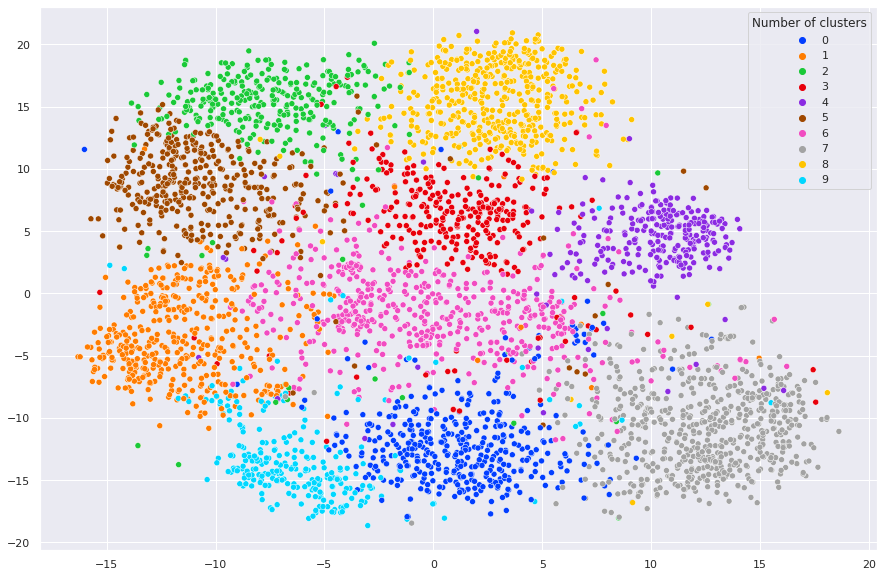

In [8]:
sns.set(rc={'figure.figsize':(15,10)})
palette = sns.color_palette("bright", NUM_CLUSTERS)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans_model.labels_, legend='full', palette=palette)
plt.legend(title="Number of clusters")
plt.savefig(NAME_PATH_CLUST+'clusters.png', dpi=300)

In [9]:
import collections
data = pd.read_csv('data//df_2.csv')

data_new = pd.DataFrame()
data_new['head'] = list(range(max(data['head'])+1))
data_new['volume'] = [sum(data[data['head'] == i]['amount']) for i in range(max(data['head'])+1)]
data_new['volume_clust'] = pd.qcut(data_new.volume, q=10) #, labels= [str(i) for i in range(10)]
data_new['purchases'] = [len(data[data['head'] == i]) for i in range(max(data['head'])+1)]  
data_new['purchases_clust'] = pd.qcut(data_new.purchases, q=10) 
data_new['stability'] = [len(set(data[data['head'] == i]['tail'])) for i in range(max(data['head'])+1)] 
data_new['stability_clust'] = pd.qcut(data_new.stability, q=10) 
data_new['type'] = [sorted(collections.Counter(set(data[data['head'] == i]['category'])), key=collections.Counter(set(data[data['head'] == i]['category'])).get, reverse=True)[0] for i in range(max(data['head'])+1)] 
data_new['district'] = [sorted(collections.Counter(set(data[data['head'] == i]['district'])), key=collections.Counter(set(data[data['head'] == i]['district'])).get, reverse=True)[0] for i in range(max(data['head'])+1)] 

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


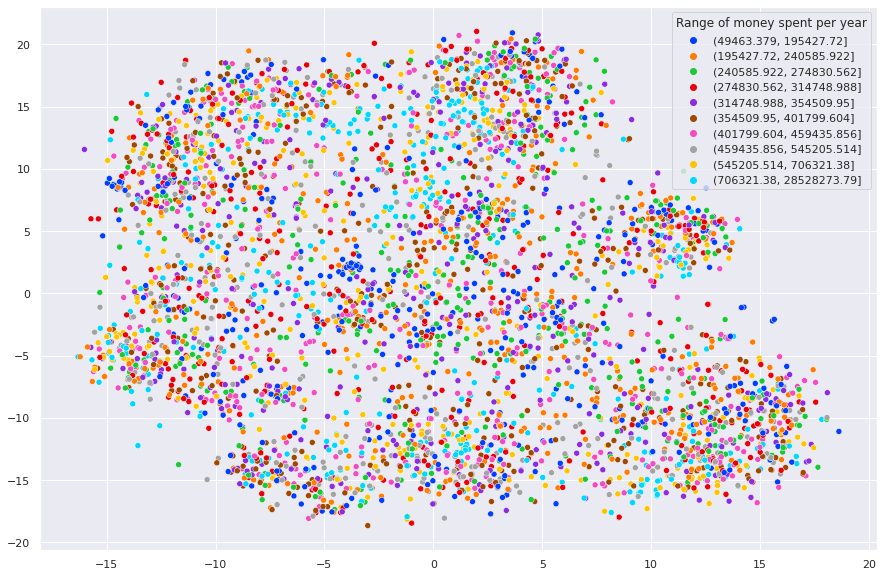

In [10]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data_new['volume_clust'], legend='full', palette=palette)
plt.legend(title="Range of money spent per year")
plt.savefig(NAME_PATH_CLUST+'money_spent.png', dpi=300)

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


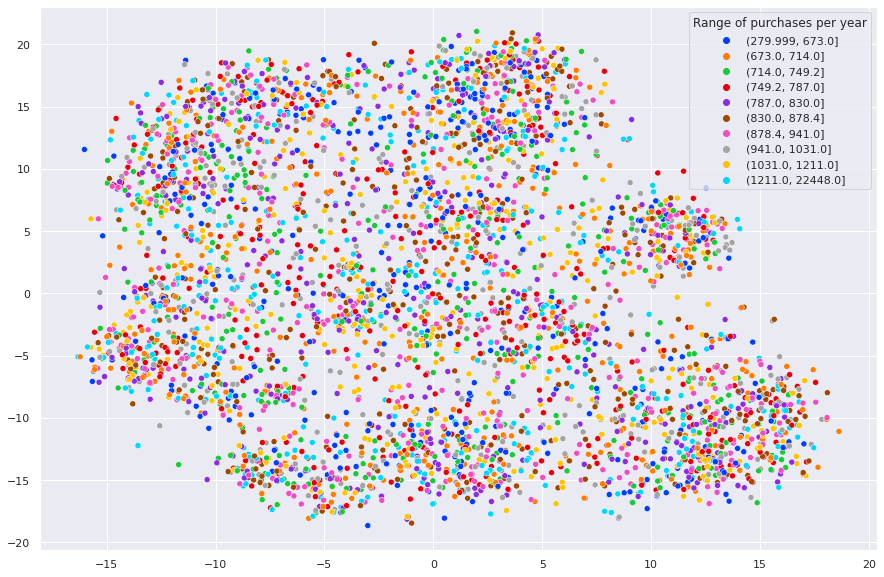

In [11]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data_new['purchases_clust'], legend='full', palette=palette)
plt.legend(title="Range of purchases per year")
plt.savefig(NAME_PATH_CLUST+'purchases.png', dpi=300)

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


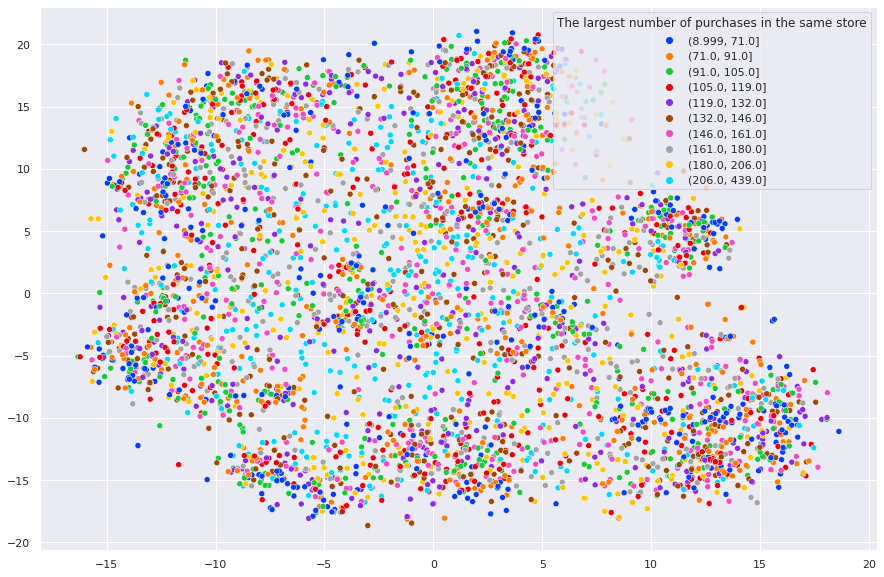

In [12]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data_new['stability_clust'], legend='full', palette=palette)
plt.legend(title="The largest number of purchases in the same store")
plt.savefig(NAME_PATH_CLUST+'stability.png', dpi=300)

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


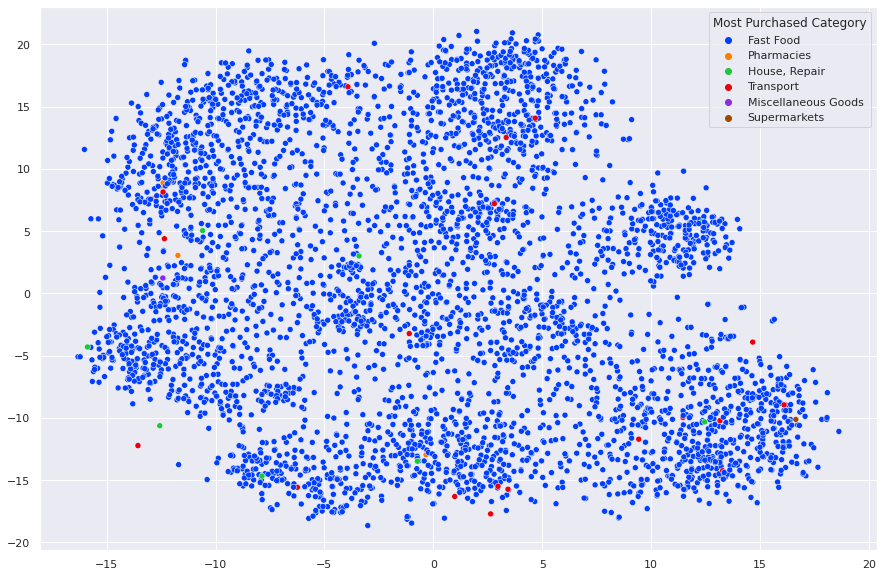

In [13]:
palette = sns.color_palette("bright", len(data_new['type'].unique()))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data_new['type'], legend='full', palette=palette)
plt.legend(title="Most Purchased Category")
plt.savefig(NAME_PATH_CLUST+'popular_category.png', dpi=300)

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


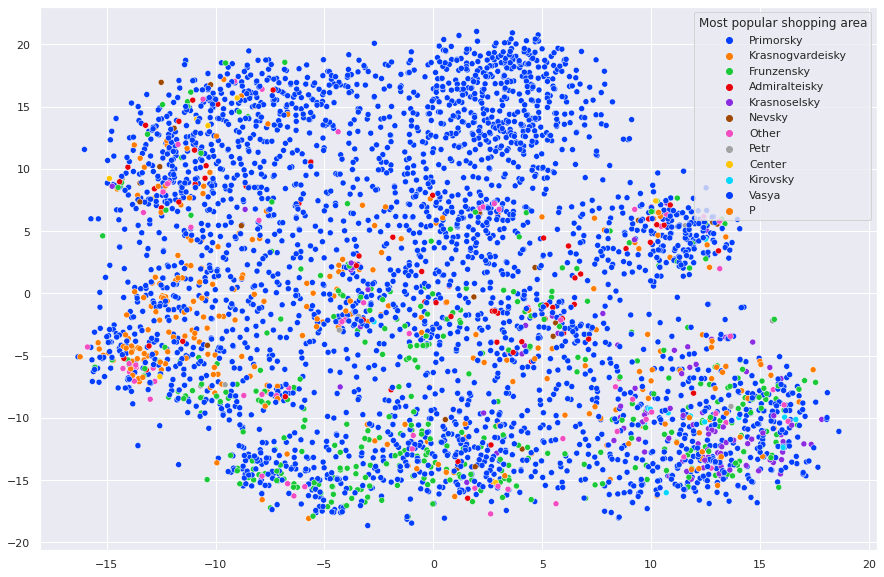

In [15]:
dict_district = {
    'Приморский район': 'Primorsky',
    'Кировский район': 'Kirovsky',
    'Красногвардейский район': 'Krasnogvardeisky',
    'Фрунзенский район': 'Frunzensky',
    'Красносельский район': 'Krasnoselsky',
    'Другое': 'Other',
    'Колпинский район': 'Kolpinsky',
    'Московский район': 'Moskovsky',
    'Адмиралтейский район': 'Admiralteisky',
    'Выборгский район': 'Vyborgsky',
    'Невский район': 'Nevsky',
    'Калининский район': 'Kalininsky',
    'Пушкинский район': 'Pushkinsky',
    'Центральный район': 'Center',
    'Петродворцовый район': 'Petr',
    'Василеостровский район': 'Vasya',
    'Кронштадтский район': 'Kronsh',
    'Петроградский район': 'P'
}

data_new['district'] = [dict_district[i] for i in data_new['district']]

palette = sns.color_palette("bright", data_new['district'].nunique())
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data_new['district'], legend='full', palette=palette)
plt.legend(title="Most popular shopping area")
plt.savefig(NAME_PATH_CLUST+'district.png', dpi=300)

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


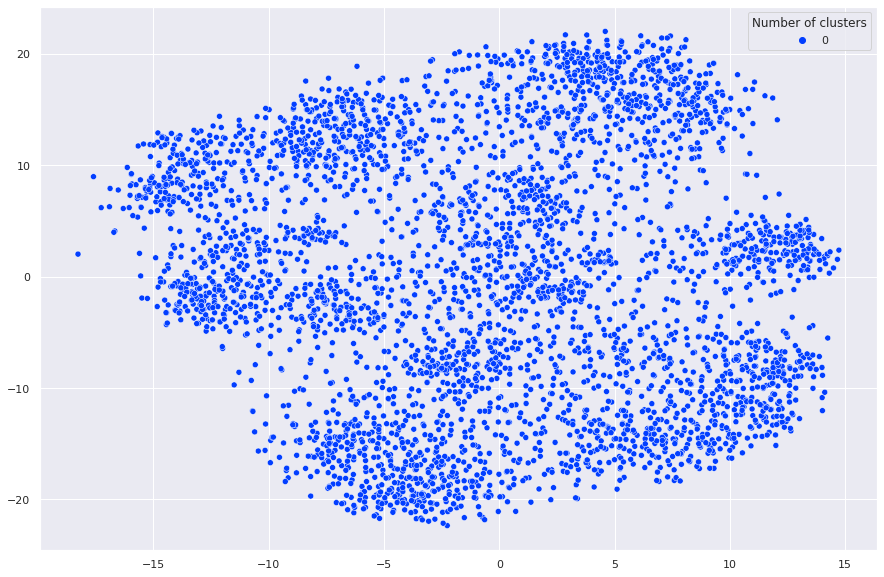

In [16]:
from sklearn.cluster import KMeans, DBSCAN
# kmeans_model = KMeans(n_clusters=NUM_CLUSTERS, init="k-means++")
dbscan_model = DBSCAN(eps=1.1, min_samples=100)
dbscan_model.fit(np.array(cust_embed))

tsne = TSNE(n_components=2, perplexity=150.0)
X_embedded = tsne.fit_transform(cust_embed)
                 
palette = sns.color_palette("bright", len(set(dbscan_model.labels_)))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=dbscan_model.labels_, legend='full', palette=palette)
plt.legend(title="Number of clusters")
plt.savefig(NAME_PATH_CLUST+'clusters_DBSCAN.png', dpi=300)

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


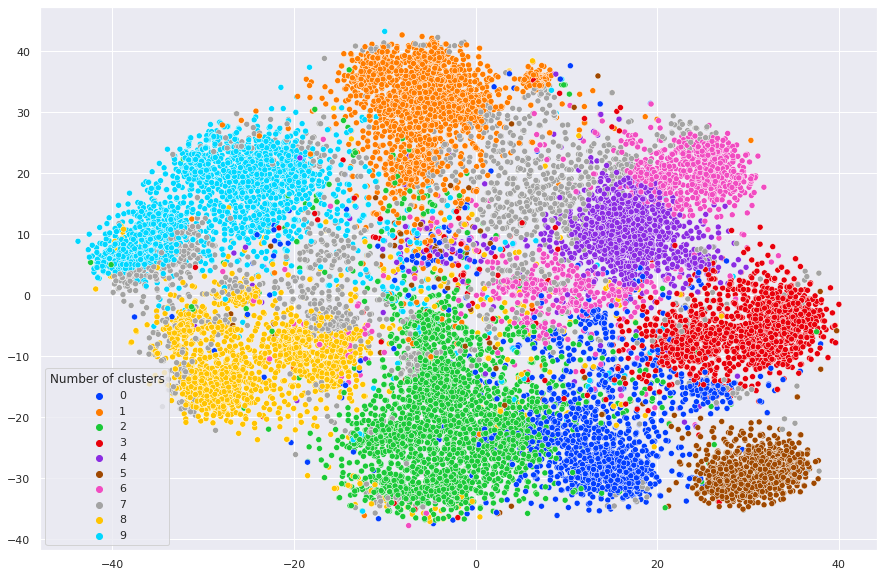

In [17]:
NUM_CLUSTERS = 10

shop_embed = entity_embedding_tensor[max(data['head']+1):-11]

tsne = TSNE(n_components=2, perplexity=150.0)
X_embedded = tsne.fit_transform(shop_embed)

kmeans_model = KMeans(n_clusters=NUM_CLUSTERS, init="k-means++")
kmeans_model.fit(np.array(shop_embed))

plt.figure(figsize=(15,10))
palette = sns.color_palette("bright", len(set(kmeans_model.labels_)))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=kmeans_model.labels_, legend='full', palette=palette)
plt.legend(title="Number of clusters")
plt.savefig(NAME_PATH_CLUST+'clusters_shops.png', dpi=300)

In [18]:
data_new_shop = pd.DataFrame()
data_new_shop['tail'] = list(range((max(data['head'])+1),max(data['tail'])))
data_new_shop['category'] = [list(data[data['tail'] == i]['category'])[0] for i in range(max(data['head'])+1,max(data['tail']))]

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


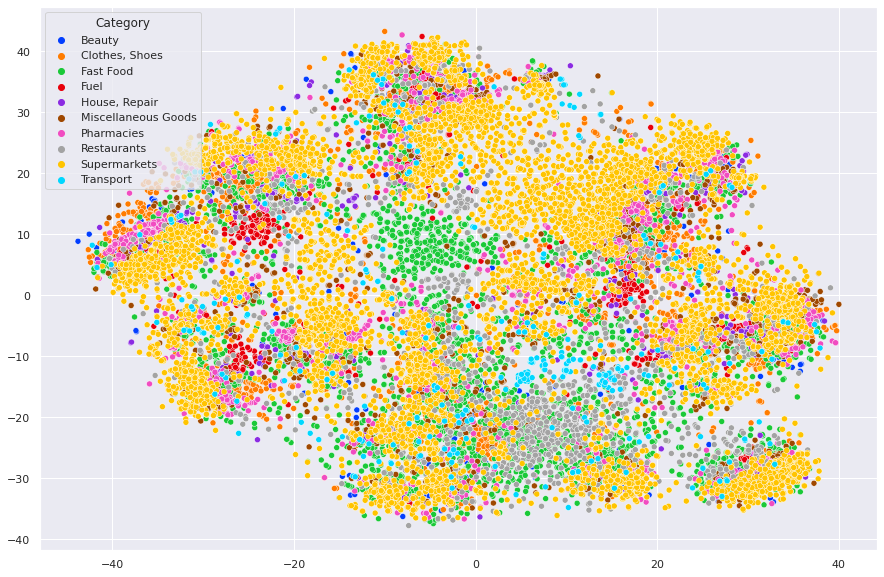

In [19]:
plt.figure(figsize=(15,10))
palette = sns.color_palette("bright", len(data_new_shop['category'].unique()))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data_new_shop['category'], legend='full', palette=palette)
plt.legend(title="Category")

/data/home/eegorova/.conda/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


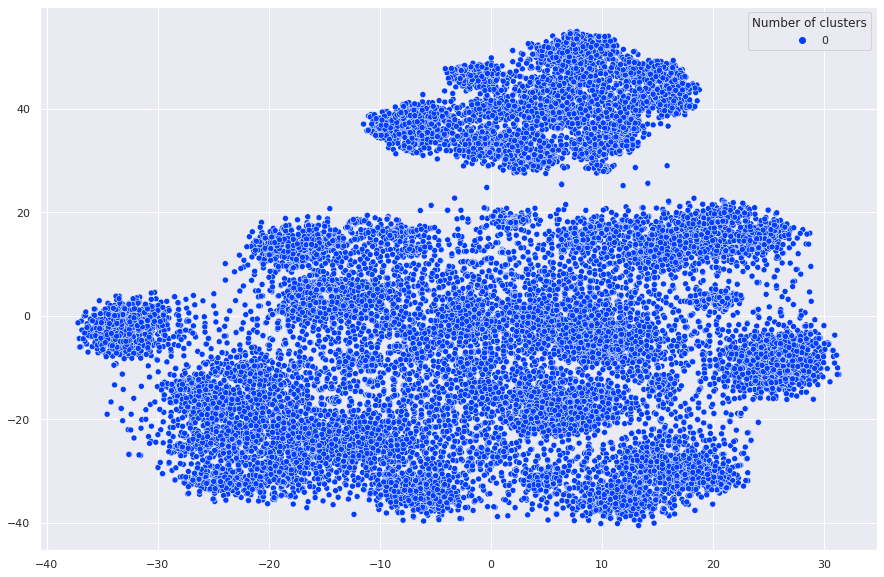

In [20]:
embed = entity_embedding_tensor

from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=NUM_CLUSTERS, init="k-means++")
kmeans_model.fit(embed)

tsne = TSNE(n_components=2, perplexity=150.0)
X_embedded = tsne.fit_transform(embed)

sns.set(rc={'figure.figsize':(15,10)})
palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=[0]*len(X_embedded[:,0]), legend='full', palette=palette)
plt.legend(title="Number of clusters")
plt.savefig(NAME_PATH_CLUST+'clusters_shops_and_users.png', dpi=300)